# Challenge 3 - High Refund

## 1️⃣ Intro
### 🕵️‍♀️ Investigate High Refund Listings

Hello, fellow SP-API experts!


I am writing to you on behalf of the 🪄ListingsWizard company. <br />
Thanks to your previous work, our company sales have been performing as expected. However, there seems to be signs of **unusually high** refund rate amongst our listings. <br />
Can you please investigate and recover the sales? My team has provided data access below to assist your investigation.


Yours,
ListingsWizard

---

_* The following scenario uses a mock server and mock data. No real data is used._

### Your Quest
1. Analyze data 📈
2. Identify root cause 👀
3. Submit a fix 🔧

On correct submission, you will receive a passcode. First person to receive the correct passcode will be the **challenge winner** 👑


## 2️⃣ Setup
### 🧰 Installing Selling Partner API SDK

The **Amazon Selling Partner API SDK** is an official Amazon library that simplifies integration with Amazon’s SP-API. It handles things like authentication, request signing, and response parsing — so you can focus on building your solution instead of dealing with low-level API mechanics.

With this SDK, you can easily access endpoints like Orders, Listings, Reports, Feeds, and **Buy Shipping** using clean, structured Python code.

📚 Learn more or explore the source on GitHub: https://github.com/amzn/selling-partner-api-sdk/tree/main


📦 To install the SDK, run the below block 👇

In [2]:
pip install amzn-sp-api pandas matplotlib

Looking in indexes: https://pypi.org/simple, https://plugin.us-east-1.prod.workshops.aws

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


---

## 3️⃣ Let's Data Kiosk!

Data Kiosk lets you submit GraphQL queries from a variety of schemas to help manage selling partner businesses. You can use the following SDK to call Data Kiosk API.


### 🔍 What is Data Kiosk?

It’s your all-access pass to query Amazon datasets like sales, traffic, and profitability using GraphQL.

You can:

- Submit custom queries
- Check their status
- Download results
  
🙌 Time to get seller data with the power of GraphQL!



---

### 🐛 Mocking the SDK


Luckily the Amazon Solution Architect team created a mock server that can replicate the API responses without having credentials.

Below you will find `mock_oauth_endpoint` and `mock_endpoint` variables that can be used to skip the credentials.

In [3]:
from spapi.models.datakiosk_v2023_11_15 import GetDocumentResponse, CreateQueryResponse, GetQueriesResponse, Query
from spapi import SPAPIConfig, SPAPIClient, ApiException, QueriesApi, ListingsApi

# Configuration for mock SP-API
mock_oauth_endpoint = "http://54.173.241.222:80/auth/o2/token"
mock_endpoint = "http://54.173.241.222:80"

config = SPAPIConfig(
    client_id="Chris",
    client_secret="Khoury",
    refresh_token="FakeToken",
    region="NA"
)
client = SPAPIClient(config, endpoint=mock_endpoint, oauth_endpoint=mock_oauth_endpoint)

data_kiosk_api = QueriesApi(client.api_client)
listings_api = ListingsApi(client.api_client)

2025-07-01 09:19:42,526 ERROR Token request failed.
ERROR:spapi.auth.lwa_request:Token request failed.


LwaException: LWA Error - Code: server_error, Message: Token request failed.

---

### 🚶‍♂️ Steps to Get Data Kiosk Reports

#### 🖥️ Step 1: Paste Your Query Below

💡 Use the [Data Kiosk Schema Explorer UI](https://sellercentral.amazon.com/datakiosk-schema-explorer?schema=analytics_salesAndTraffic_2024_04_24) to build your perfect query, for now, you can use the one we built for you here:

In [12]:
graphql_query_str = (
    "query { analytics_economics_2024_03_15 { economics( "
    "marketplaceIds: [\"ATVPDKIKX0DER\"], "
    "startDate: \"2025-06-01\", endDate: \"2025-06-05\", "
    "aggregateBy: { date: DAY, productId: MSKU } ) { "
    "msku startDate endDate sales { "
    "unitsOrdered unitsRefunded "
    "orderedProductSales { amount currencyCode } "
    "refundedProductSales { amount currencyCode } "
    "} } } }"
)

graphql_query = {"query": graphql_query_str}

---

#### 🚀 Step 2: Send the Query
Let Amazon know you’re ready to roll by calling `create_query`.

In [13]:
# Tell Amazon to start processing your query
create_query_response = data_kiosk_api.create_query(body=graphql_query)
print("✅ Query submitted! Response:", create_query_response)

✅ Query submitted! Response: {'query_id': '1000003'}


---

#### ⏳ Step 3: Check If Your Data Is Ready

You can either:

- Keep checking with `get_query`, or
- 🧠 Be smart _well-architected_ and subscribe to the [DATA_KIOSK_QUERY_PROCESSING_FINISHED](https://developer-docs.amazon.com/sp-api/docs/data-kiosk-notification) notification for automatic updates.

Here, we’ll use polling just once for simplicity - if data is ready a `dataDocumentId` attribute will be reutrned:

In [14]:
# Check the status of your query
get_query_response = data_kiosk_api.get_query(query_id=create_query_response.query_id)
print("⏱️ Query status:", get_query_response)

⏱️ Query status: {'created_time': datetime.datetime(2025, 7, 17, 11, 25, 13, 645000, tzinfo=tzlocal()),
 'data_document_id': 'usecase_3_document_id.amzn.100003',
 'error_document_id': None,
 'pagination': None,
 'processing_end_time': datetime.datetime(2025, 7, 17, 11, 25, 13, 645000, tzinfo=tzlocal()),
 'processing_start_time': datetime.datetime(2025, 7, 17, 11, 25, 13, 645000, tzinfo=tzlocal()),
 'processing_status': 'DONE',
 'query': 'query { analytics_economics_2024_03_15 { economics( marketplaceIds: '
          '["ATVPDKIKX0DER"], startDate: "2025-06-01", endDate: "2025-06-05", '
          'aggregateBy: { date: DAY, productId: MSKU } ) { msku startDate '
          'endDate sales { unitsOrdered unitsRefunded orderedProductSales { '
          'amount currencyCode } refundedProductSales { amount currencyCode } '
          '} } } }',
 'query_id': '1000003'}


---

#### 📦 Step 4: Get Your Data!

Once the query is ready, you’ll receive a `dataDocumentId`. Use it to grab the results with `get_document` endpoint.

In [16]:
# Now let's get the actual data!
get_document = data_kiosk_api.get_document(document_id=get_query_response.data_document_id)
print("📊 Here's your data:", get_document)

📊 Here's your data: {'document_id': 'usecase_3_document_id.amzn.100003',
 'document_url': "{'data': {'analytics_economics_2024_03_15': {'economics': "
                 "[{'msku': 'BICYCLE-RED-L', 'startDate': '2025-06-01', "
                 "'endDate': '2025-06-01', 'sales': {'unitsOrdered': 100, "
                 "'unitsRefunded': 50, 'orderedProductSales': {'amount': "
                 "2000.0, 'currencyCode': 'USD'}, 'refundedProductSales': "
                 "{'amount': 1000.0, 'currencyCode': 'USD'}}}, {'msku': "
                 "'BICYCLE-GRAY-M', 'startDate': '2025-06-01', 'endDate': "
                 "'2025-06-01', 'sales': {'unitsOrdered': 60, 'unitsRefunded': "
                 "30, 'orderedProductSales': {'amount': 1200.0, "
                 "'currencyCode': 'USD'}, 'refundedProductSales': {'amount': "
                 "600.0, 'currencyCode': 'USD'}}}, {'msku': 'BICYCLE-BLUE-M', "
                 "'startDate': '2025-06-01', 'endDate': '2025-06-01', 'sales': "
           

---

### 📊 Visualize Your Economics Data

🧠 What This Shows - Let’s bring the numbers to life!

- You'll see a bar chart of refund rates.
- High-refund SKUs will be marked in red.
- Easy to tell which MSKUs are the problem.

Make sure you’ve run the cell above so `get_document_response` is available.


,MSKU,Units Ordered,Units Refunded,Ordered Sales ($),Refunded Sales ($),Refund Rate (%),$ Refund Rate (%),High Refund?
0,BICYCLE-RED-L,100,50,2000.0,1000.0,50.00,50.00,True
1,BICYCLE-GRAY-M,60,30,1200.0,600.0,50.00,50.00,True
2,BICYCLE-BLUE-M,80,5,1600.0,100.0,6.25,6.25,False


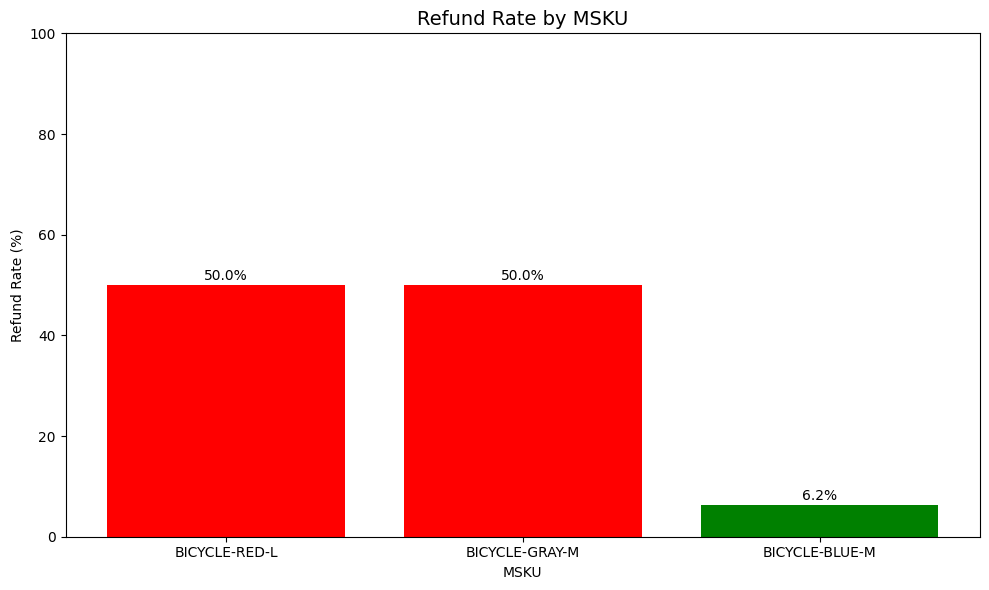

In [17]:
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Safely convert the string to a dictionary
parsed_document = ast.literal_eval(get_document.document_url)

# Extract the economics data
economics_data = parsed_document["data"]["analytics_economics_2024_03_15"]["economics"]


# Build DataFrame
df = pd.DataFrame([
    {
        "MSKU": item["msku"],
        "Units Ordered": item["sales"]["unitsOrdered"],
        "Units Refunded": item["sales"]["unitsRefunded"],
        "Ordered Sales ($)": item["sales"]["orderedProductSales"]["amount"],
        "Refunded Sales ($)": item["sales"]["refundedProductSales"]["amount"]
    }
    for item in economics_data
])

# Calculate refund rates
df["Refund Rate (%)"] = (df["Units Refunded"] / df["Units Ordered"]) * 100
df["$ Refund Rate (%)"] = (df["Refunded Sales ($)"] / df["Ordered Sales ($)"]) * 100

# Flag high refund rate listings
df["High Refund?"] = df["Refund Rate (%)"] > 30

# Display table
display(df.sort_values("Refund Rate (%)", ascending=False))

# Plot refund rates
plt.figure(figsize=(10, 6))
bars = plt.bar(df["MSKU"], df["Refund Rate (%)"], color=["red" if high else "green" for high in df["High Refund?"]])
plt.title("Refund Rate by MSKU", fontsize=14)
plt.ylabel("Refund Rate (%)")
plt.xlabel("MSKU")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=10)

plt.ylim(0, 100)
plt.tight_layout()
plt.show()


---

## 4️⃣ Troubleshooting: 

### 🫆 Clue

Looks like there are a few SKUs that have up to 50% of refund rate! 

Use the code below to call getListingsItems operation on one of the SKUs with high refund.


In [8]:
import json
get_listing = listings_api.get_listings_item('AMY6FKRUBY7XV', 
                                             'BICYCLE-GRAY-M',
                                             ['ATVPDKIKX0DER'], 
                                             included_data=['attributes', 'issues','summaries'])

print("🛍️ Here's your listing: \n", json.dumps(get_listing.to_dict(), indent=4, default=str))

### 🕵️ New Clue

There is no `ERROR` severity issues on the listing! What else could have gone wrong?

Our team just pulled a `GET_V2_SELLER_PERFORMANCE_REPORT` report. It might be relevant to the investigation!
<details>
<summary><strong>GET_V2_SELLER_PERFORMANCE_REPORT report</strong></summary>
    
```
{
  "accountStatuses": [
    {
      "marketplaceId": "ATVPDKIKX0DER",
      "status": "NORMAL"
    }
  ],
  "performanceMetrics": [
    {
      "lateShipmentRate": {
        "reportingDateRange": {
          "reportingDateFrom": "2025-05-27T00:00:00Z",
          "reportingDateTo": "2025-06-25T23:59:59Z"
        },
        "status": "GOOD",
        "targetValue": 0.04,
        "targetCondition": "LESS_THAN",
        "orderCount": 0,
        "lateShipmentCount": 0,
        "rate": 0
      },
      "lateShipmentRateList": [
        {
          "reportingDateRange": {
            "reportingDateFrom": "2025-06-16T00:00:00Z",
            "reportingDateTo": "2025-06-25T23:59:59Z"
          },
          "status": "GOOD",
          "targetValue": 0.04,
          "targetCondition": "LESS_THAN",
          "orderCount": 0,
          "lateShipmentCount": 0,
          "rate": 0
        },
        {
          "reportingDateRange": {
            "reportingDateFrom": "2025-05-27T00:00:00Z",
            "reportingDateTo": "2025-06-25T23:59:59Z"
          },
          "status": "GOOD",
          "targetValue": 0.04,
          "targetCondition": "LESS_THAN",
          "orderCount": 0,
          "lateShipmentCount": 0,
          "rate": 0
        }
      ],
      "invoiceDefectRate": {},
      "orderDefectRate": {
        "afn": {},
        "mfn": {
          "reportingDateRange": {
            "reportingDateFrom": "2025-04-12T00:00:00Z",
            "reportingDateTo": "2025-06-10T23:59:59Z"
          },
          "status": "GOOD",
          "targetValue": 0.01,
          "targetCondition": "LESS_THAN",
          "orderWithDefects": {
            "status": "GOOD",
            "count": 0
          },
          "claims": {
            "status": "NONE",
            "count": 0
          },
          "chargebacks": {
            "status": "NONE",
            "count": 0
          },
          "negativeFeedback": {
            "status": "NONE",
            "count": 0
          },
          "orderCount": 0,
          "rate": 0,
          "fulfillmentType": "MFN"
        }
      },
      "onTimeDeliveryRate": {
        "reportingDateRange": {
          "reportingDateFrom": "2025-05-17T00:00:00Z",
          "reportingDateTo": "2025-06-15T23:59:59Z"
        },
        "status": "GOOD",
        "targetValue": 0.97,
        "targetCondition": "GREATER_THAN",
        "shipmentCountWithValidTracking": 0,
        "onTimeDeliveryCount": 0,
        "rate": 0
      },
      "unitOnTimeDeliveryRate": {
        "reportingDateRange": {
          "reportingDateFrom": "2025-06-05T00:00:00Z",
          "reportingDateTo": "2025-06-18T23:59:59Z"
        },
        "status": "GOOD",
        "targetValue": 0.9,
        "targetCondition": "GREATER_THAN",
        "unitOnTimeDeliveryCount": 0,
        "totalUnitCount": 0,
        "rate": 0
      },
      "validTrackingRate": {
        "reportingDateRange": {
          "reportingDateFrom": "2025-05-17T00:00:00Z",
          "reportingDateTo": "2025-06-15T23:59:59Z"
        },
        "status": "GOOD",
        "targetValue": 0.95,
        "targetCondition": "GREATER_THAN",
        "shipmentCount": 0,
        "validTrackingCount": 0,
        "rate": 0
      },
      "preFulfillmentCancellationRate": {
        "reportingDateRange": {
          "reportingDateFrom": "2025-06-18T00:00:00Z",
          "reportingDateTo": "2025-06-24T23:59:59Z"
        },
        "status": "GOOD",
        "targetValue": 0.025,
        "targetCondition": "LESS_THAN",
        "orderCount": 0,
        "cancellationCount": 0,
        "rate": 0
      },
      "warningStates": [],
      "accountHealthRating": {
        "ahrStatus": "GREAT",
        "reportingDateRange": {
          "reportingDateFrom": "2024-12-27T00:00:00Z",
          "reportingDateTo": "2025-06-25T23:59:59Z"
        },
        "ahrScore": 200
      },
      "listingPolicyViolations": {
        "reportingDateRange": {
          "reportingDateFrom": "2024-12-28T00:00:00Z",
          "reportingDateTo": "2025-06-25T23:59:59Z"
        },
        "status": "GOOD",
        "targetValue": 0,
        "targetCondition": "EQUALS",
        "defectsCount": 0
      },
      "productAuthenticityCustomerComplaints": {},
      "productConditionCustomerComplaints": {},
      "productSafetyCustomerComplaints": {},
      "receivedIntellectualPropertyComplaints": {},
      "restrictedProductPolicyViolations": {},
      "suspectedIntellectualPropertyViolations": {},
      "foodAndProductSafetyIssues": {},
      "customerProductReviewsPolicyViolations": {},
      "otherPolicyViolations": {},
      "documentRequests": {},
      "policyViolationWarnings": {},
      "marketplaceId": "ATVPDKIKX0DER"
    }
  ]
}
```

</details>

## 5️⃣ Resolution: 


### 🧐 Analysis

We see `lateShipmentRate` of 0.4! 🤦‍♀️

```
"lateShipmentRate": {
        "reportingDateRange": {
          "reportingDateFrom": "2025-05-27T00:00:00Z",
          "reportingDateTo": "2025-06-25T23:59:59Z"
        },
        "status": "GOOD",
        "targetValue": 0.04,
        "targetCondition": "LESS_THAN",
        "orderCount": 0,
        "lateShipmentCount": 0,
        "rate": 0
      },
```

That means majority of the orders for this SKU have been delayed. 

Looking at the getListingsItem response, there is no `lead_time_to_ship_max_days` attribute.

```
"fulfillment_availability": [
            {
                "fulfillment_channel_code": "DEFAULT",
                "quantity": 3
            }
        ],
```

But in our company's internal record, it shows that lead time to ship is suppose to be *10 days* for this product type. 🚚 Why would this happen?

Our team pulled a historical patchListingsItem submission. Can you observe and see why the lead time to ship value could have been wrong?

<details>
<summary><strong>Historical Submission</strong></summary>
    
```
{
    "productType": "PRODUCT",
    "patches": [
        {
            "op": "replace",
            "path": "/attributes/fulfillment_availability",
            "value": [
                {
                    "fulfillment_channel_code": "DEFAULT",
                    "quantity": 4
                }
            ]
        }
    ]
}
```
</details>


### Future Submissions

Our team has manually changed `lead_time_to_ship_max_days` back to 10 days in Seller Central. 

But we need to make sure we don't accidentally override the value again in the future. 

The team now need to update inventory to 4. Can you help come up with a request to update inventory without providing `lead_time_to_ship_max_days` attribute?

<details>
<summary><strong>💡 HINT</strong></summary>
    
_There is a [new merge operation](https://developer-docs.amazon.com/sp-api/changelog/update-listings-items-v2021-08-01-api-and-json_listing_feed-now-include-a-json-patch-merge-operation) introduced into the Listings APIs. You no longer need to pass optional field `lead_time_to_ship_max_days` when updating inventory only._

</details>



In [ ]:
body = {
    "productType": "PRODUCT",
    "patches": [
        {
            "op": "merge",
            "path": "/attributes/fulfillment_availability",
            "value": [
                {
                    "fulfillment_channel_code": "DEFAULT",
                    "quantity": 4
                }
            ]
        }
    ]
}
patch_listing = listings_api.patch_listings_item('AMY6FKRUBY7XV', 'BICYCLE-GRAY-M',['ATVPDKIKX0DER'], body)
print("💾 Submission result: \n", json.dumps(patch_listing.to_dict(), indent=4, default=str))